In [ ]:
!pip install librosa soundfile matplotlib scikit-learn

In [23]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Extract MFCC features from audio
def extract_mfcc_features(y, sr, n_mfcc=13, n_fft=2048, hop_length=512):

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Extract additional spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    features = []

    # MFCC statistics
    features.extend([np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
                    np.max(mfcc, axis=1), np.min(mfcc, axis=1)])

    # Delta MFCC statistics
    features.extend([np.mean(mfcc_delta, axis=1), np.std(mfcc_delta, axis=1)])

    # Delta-delta MFCC statistics
    features.extend([np.mean(mfcc_delta2, axis=1), np.std(mfcc_delta2, axis=1)])

    # Additional spectral features
    features.extend([
        np.mean(spectral_centroid), np.std(spectral_centroid),
        np.mean(spectral_rolloff), np.std(spectral_rolloff),
        np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
        np.mean(zero_crossing_rate), np.std(zero_crossing_rate)
    ])

    # Flatten all features into a single vector
    feature_vector = np.concatenate([f.flatten() if hasattr(f, 'flatten') else [f] for f in features])

    return feature_vector

In [26]:
# Create synthetic dataset
def create_synthetic_audio_dataset(n_samples_per_class=50):

    X = []
    y = []
    class_names = ['Sine Wave', 'Noise', 'Chirp', 'Sawtooth']

    sr = 22050
    duration = 2
    t = np.linspace(0, duration, sr * duration)

    for class_idx, class_name in enumerate(class_names):
        print(f"Generating {n_samples_per_class} samples for {class_name}...")

        for i in range(n_samples_per_class):
            if class_name == 'Sine Wave':
                # Generate sine waves with different frequencies
                freq = np.random.uniform(200, 800)
                audio = np.sin(2 * np.pi * freq * t)

            elif class_name == 'Noise':
                # Generate different types of noise
                audio = np.random.normal(0, 0.1, len(t))

            elif class_name == 'Chirp':
                # Generate chirp signals (frequency sweep)
                f0, f1 = np.random.uniform(100, 400), np.random.uniform(800, 1200)
                audio = np.sin(2 * np.pi * (f0 * t + (f1 - f0) * t**2 / (2 * duration)))

            elif class_name == 'Sawtooth':
                # Generate sawtooth waves
                freq = np.random.uniform(100, 500)
                audio = 2 * (t * freq - np.floor(0.5 + t * freq))

            # Add some noise
            audio += np.random.normal(0, 0.01, len(audio))

            # Normalize audio
            audio = audio / np.max(np.abs(audio))

            # Extract features
            features = extract_mfcc_features(audio, sr)

            X.append(features)
            y.append(class_idx)

    return np.array(X), np.array(y), class_names

In [27]:
# Load and process real audio examples
def load_librosa_examples():

    X = []
    y = []
    class_names = []

    # Use librosa's built-in examples
    examples = [
        ('trumpet', 0),
        ('nutcracker', 1),
        ('brahms', 2)
    ]

    for example_name, label in examples:
        try:
            audio_path = librosa.ex(example_name)
            y_audio, sr = librosa.load(audio_path)

            # Split audio into shorter segments for more data
            segment_length = sr * 2
            hop_size = sr * 1

            # Generate overlapping segments
            n_segments = max(1, (len(y_audio) - segment_length) // hop_size + 1)

            segments_added = 0
            for i in range(n_segments):
                start = i * hop_size
                end = start + segment_length

                if end <= len(y_audio):
                    segment = y_audio[start:end]

                    features = extract_mfcc_features(segment, sr)
                    X.append(features)
                    y.append(label)
                    segments_added += 1

            print(f"  {example_name}: {segments_added} segments created")
            class_names.append(example_name.capitalize())

        except Exception as e:
            print(f"Could not load {example_name}: {e}")

    # Check if we have enough samples per class
    if len(X) > 0:
        unique, counts = np.unique(y, return_counts=True)
        min_samples = np.min(counts)
        print(f"  Minimum samples per class: {min_samples}")

        if min_samples >= 4:
            return np.array(X), np.array(y), class_names
        else:
            print("  Not enough samples per class for reliable classification")
            return None, None, None
    else:
        return None, None, None

In [28]:
# Train and evaluate classification models
def train_classifiers(X_train, X_test, y_train, y_test, class_names):

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42),
        'SVM (Linear)': SVC(kernel='linear', random_state=42)
    }

    results = {}

    print("\n=== Training Classifiers ===")

    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")

        # Train classifier
        clf.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'classifier': clf,
            'predictions': y_pred,
            'accuracy': accuracy
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=class_names))

    return results, scaler

In [29]:
# Visualize results
def plot_results(X, y, class_names, results, y_test):

    plt.figure(figsize=(20, 12))

    #  PCA visualization of features
    plt.subplot(2, 3, 1)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    for i, class_name in enumerate(class_names):
        mask = y == i
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=[colors[i]], label=class_name, alpha=0.7)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA Visualization of Audio Features')
    plt.legend()
    plt.grid(True, alpha=0.3)

    #  Accuracy comparison
    plt.subplot(2, 3, 2)
    accuracies = [results[name]['accuracy'] for name in results.keys()]
    classifier_names = list(results.keys())

    bars = plt.bar(classifier_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.ylabel('Accuracy')
    plt.title('Classifier Performance Comparison')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)

    # Confusion matrices for each classifier
    for idx, (name, result) in enumerate(results.items()):
        plt.subplot(2, 3, 3 + idx)
        cm = confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

In [30]:
def analyze_feature_importance(classifier, feature_names=None):

    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_

        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(len(importances))]

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        print("\n=== Top 10 Most Important Features ===")
        for i in range(min(10, len(indices))):
            idx = indices[i]
            print(f"{i+1:2d}. {feature_names[idx]}: {importances[idx]:.4f}")

        # Plot feature importance
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(min(20, len(importances))), importances[indices[:20]])
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.title('Top 20 Feature Importances')

        # Cumulative importance
        plt.subplot(1, 2, 2)
        cumulative_importance = np.cumsum(importances[indices])
        plt.plot(range(len(cumulative_importance)), cumulative_importance)
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Feature Importance')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


=== MFCC Audio Classification
Loading real audio examples...
  trumpet: 4 segments created
  nutcracker: 118 segments created
  brahms: 44 segments created
  Minimum samples per class: 4
Using real audio examples: ['Trumpet', 'Nutcracker', 'Brahms']
Samples per class: {'Trumpet': np.int64(4), 'Nutcracker': np.int64(118), 'Brahms': np.int64(44)}

Dataset Info:
Total samples: 166
Number of classes: 3
Feature vector size: 112
Classes: ['Trumpet', 'Nutcracker', 'Brahms']
Samples per class: {'Trumpet': np.int64(4), 'Nutcracker': np.int64(118), 'Brahms': np.int64(44)}

Train samples: 116
Test samples: 50

=== Training Classifiers ===

Training Random Forest...
Random Forest Accuracy: 0.9600

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Trumpet       0.00      0.00      0.00         1
  Nutcracker       0.95      1.00      0.97        36
      Brahms       1.00      0.92      0.96        13

    accuracy                           0.96   

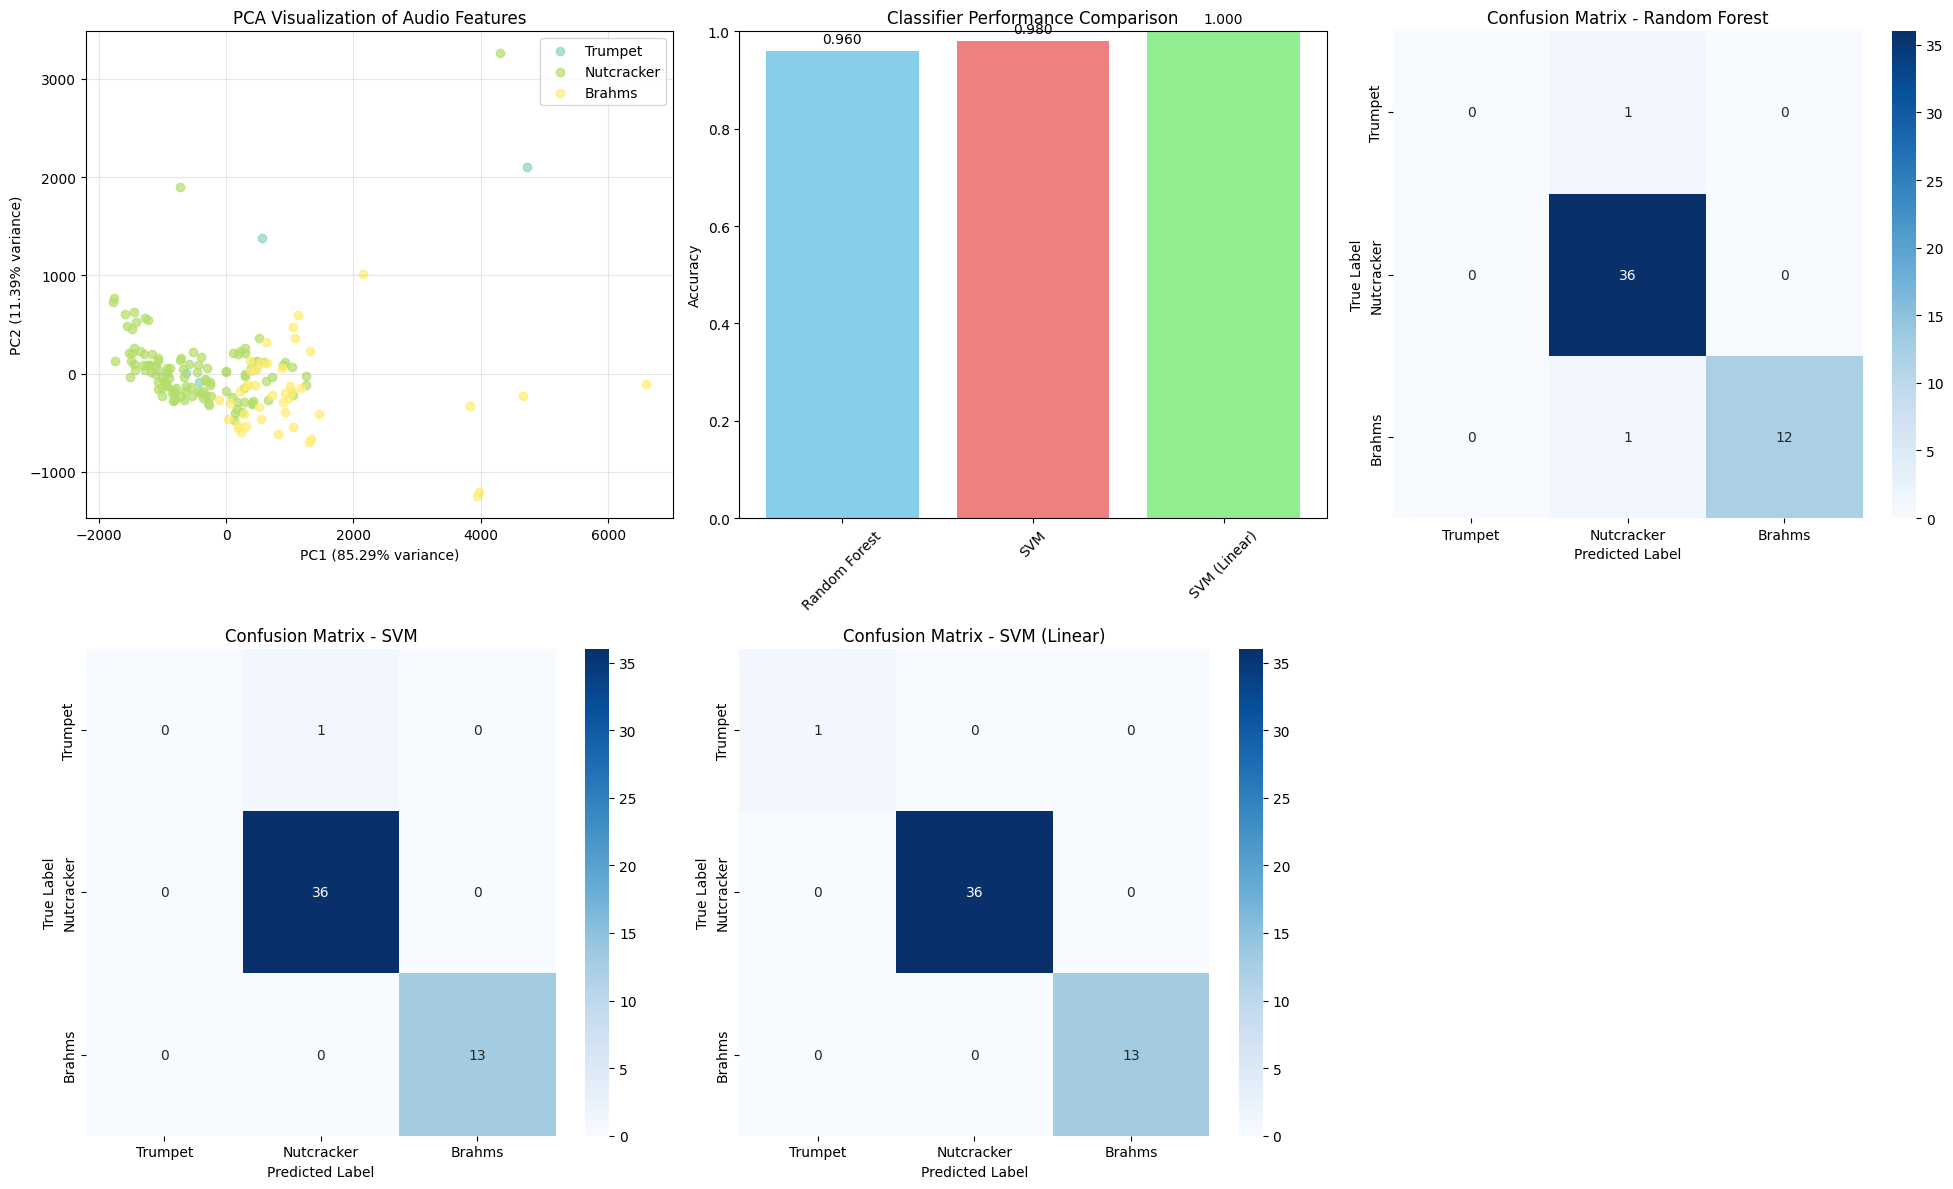


=== Feature Importance Analysis ===

=== Top 10 Most Important Features ===
 1. Feature_108: 0.1378
 2. Feature_106: 0.0828
 3. Feature_46: 0.0602
 4. Feature_71: 0.0482
 5. Feature_19: 0.0442
 6. Feature_104: 0.0277
 7. Feature_7: 0.0274
 8. Feature_1: 0.0236
 9. Feature_0: 0.0198
10. Feature_40: 0.0174


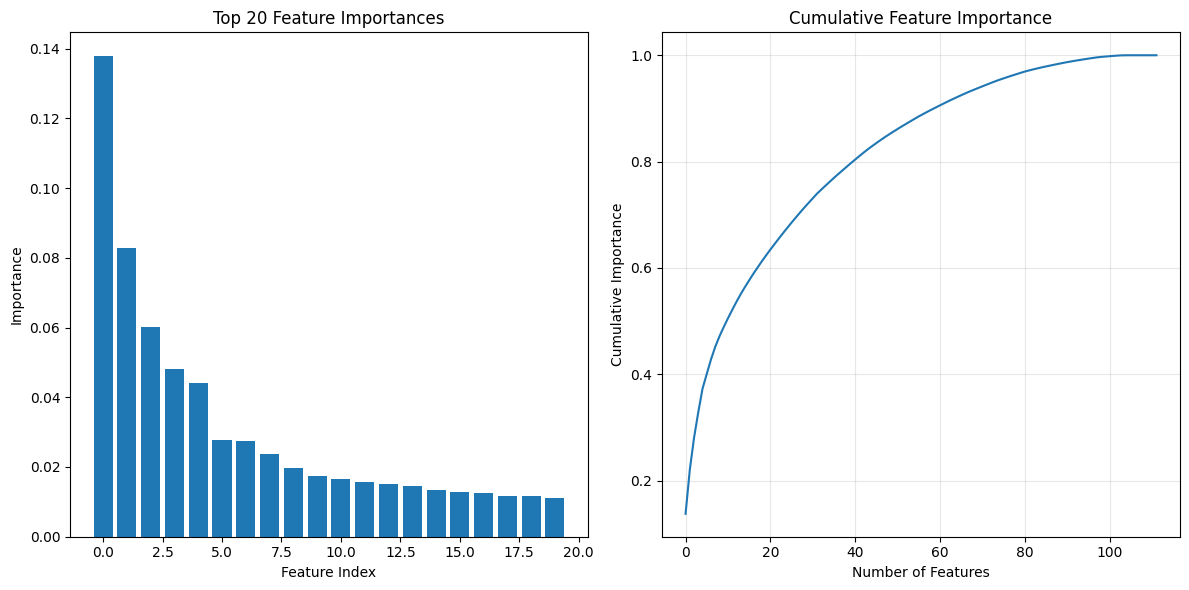


=== Example: Classifying New Audio ===
New audio sample predicted as: Brahms


In [32]:
def main():

    print("=== MFCC Audio Classification")

    # load real audio examples first
    X_real, y_real, real_class_names = load_librosa_examples()

    if X_real is not None and len(X_real) > 10:
        # Check class balance
        unique, counts = np.unique(y_real, return_counts=True)
        min_samples = np.min(counts)

        if min_samples >= 4:
            print(f"Using real audio examples: {real_class_names}")
            print(f"Samples per class: {dict(zip(real_class_names, counts))}")
            X, y, class_names = X_real, y_real, real_class_names
        else:
            print(f"Real audio has too few samples per class (min: {min_samples})")
            print("Switching to synthetic dataset...")
            X, y, class_names = create_synthetic_audio_dataset(n_samples_per_class=30)
    else:
        print("Using synthetic audio dataset...")
        X, y, class_names = create_synthetic_audio_dataset(n_samples_per_class=30)

    print(f"\nDataset Info:")
    print(f"Total samples: {len(X)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Feature vector size: {X.shape[1]}")
    print(f"Classes: {class_names}")

    # Check class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"Samples per class: {dict(zip(class_names, counts))}")

    # Ensure we have enough samples for train-test split
    min_samples = np.min(counts)
    if min_samples < 4:
        print(f"\nWarning: Some classes have too few samples ({min_samples})")
        print("Adding more synthetic data...")

        # Add synthetic data to balance classes
        additional_X, additional_y, _ = create_synthetic_audio_dataset(n_samples_per_class=20)
        X = np.vstack([X, additional_X])
        y = np.concatenate([y, additional_y + len(class_names)])

        # Update class names
        synthetic_classes = ['Synthetic_Sine', 'Synthetic_Noise', 'Synthetic_Chirp', 'Synthetic_Sawtooth']
        class_names.extend(synthetic_classes)

        print(f"Updated total samples: {len(X)}")
        print(f"Updated classes: {class_names}")

    # Split dataset with stratification if possible
    test_size = 0.3
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Using random split instead...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    # Train classifiers
    results, scaler = train_classifiers(X_train, X_test, y_train, y_test, class_names)

    print("\n=== Generating Visualizations ===")
    plot_results(X, y, class_names, results, y_test)

    print("\n=== Feature Importance Analysis ===")
    rf_classifier = results['Random Forest']['classifier']
    analyze_feature_importance(rf_classifier)

    print("\n=== Example: Classifying New Audio ===")

    # Create a new sample
    sr = 22050
    t = np.linspace(0, 2, sr * 2)
    new_audio = np.sin(2 * np.pi * 440 * t)
    new_features = extract_mfcc_features(new_audio, sr)
    new_features_scaled = scaler.transform([new_features])

    # Predict using best classifier
    best_classifier_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_classifier = results[best_classifier_name]['classifier']

    prediction = best_classifier.predict(new_features_scaled)[0]
    prediction_proba = None

    if hasattr(best_classifier, 'predict_proba'):
        prediction_proba = best_classifier.predict_proba(new_features_scaled)[0]

    print(f"New audio sample predicted as: {class_names[prediction]}")
    if prediction_proba is not None:
        print("Prediction probabilities:")
        for i, prob in enumerate(prediction_proba):
            print(f"  {class_names[i]}: {prob:.4f}")

    return X, y, class_names, results, scaler

if __name__ == "__main__":
    X, y, class_names, results, scaler = main()
